In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# Se placer dans le bon répertoire
import os
import sys

ROOT_DIR = os.path.abspath("../../")

In [4]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32)  # Les caractéristiques commencent à la colonne 1
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)     # La première colonne est la cible
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


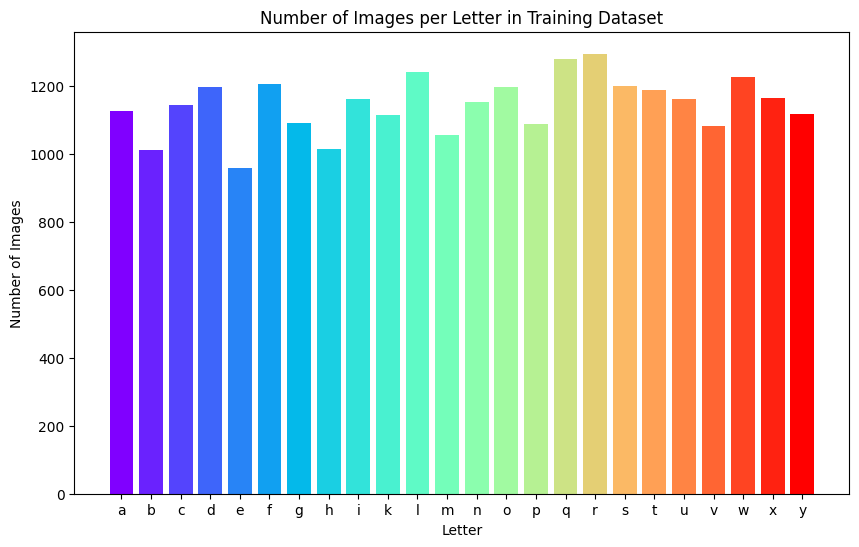

In [28]:
train_dataset_path = os.path.join(ROOT_DIR, "data/sign_mnist_train.csv")
test_dataset_path = os.path.join(ROOT_DIR, "data/sign_mnist_test.csv")

train_dataset = CustomDataset(train_dataset_path)
test_dataset = CustomDataset(test_dataset_path)

# Visualisation du nombre d'image par classe dans le jeu d'entraînement
letter_counts = {}
for _, label in train_dataset:
    letter = chr(label.item() + 97)  # Convertir le label en lettre (97 est le code ASCII pour 'a')
    if letter in letter_counts:
        letter_counts[letter] += 1
    else:
        letter_counts[letter] = 1

sorted_letters = sorted(letter_counts.keys())

# Créer l'histogramme
plt.figure(figsize=(10, 6))
colors = cm.rainbow(np.linspace(0, 1, len(sorted_letters)))
plt.bar(sorted_letters, [letter_counts[letter] for letter in sorted_letters], color=colors)
plt.xlabel('Letter')
plt.ylabel('Number of Images')
plt.title('Number of Images per Letter in Training Dataset')
plt.show()
